# Formalia:

Please read the [assignment overview page](https://github.com/lalessan/comsocsci2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday, April 5th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Course Content, Assignemnts, Assignment 2)_


Remember to include in the first cell of your notebook:
* the link to your group's Git repository
* group members' contributions

In [1]:
#Importing of packages
import nltk
from nltk import word_tokenize
import re
import numpy as np
import pandas as pd
import datetime as dt
from collections import Counter
from nltk.corpus import stopwords
import math
from wordcloud import WordCloud
english_words = set(nltk.corpus.words.words())
stopwords=set(stopwords.words('english'))
import shifterator as sh
import networkx as nx
from networkx.algorithms import community
import community as community_louvain
import netwulf as nw
import matplotlib.pyplot as plt

## Part 1: TF-IDF

For this exercise, you need the following data: 
* The r/wallstreetbets submissions (either the one provided by me [here](https://github.com/lalessan/comsocsci2021/blob/master/data/wallstreet_subs.csv.gz) or the one you downloaded in Week 6).
* The list of 15 stocks you identified in Week 6, Exercise 2.

In [2]:
#Importing the dataset
df = pd.read_csv('../assignment2/wallstreet_subs.csv')

In [3]:
#Creation and implementation of the 'textsubmission' column
x=df['title']
y=df['selftext']
x_1=[]
y_1=[]
for i in range(len(df)):
    x_1.append(x[i])
    y_1.append(y[i])
list1=[]
for i in range(len(df)):
    list1.append(x_1[i]+' '+y_1[i])
    
df['textsubmission']=list1

In [4]:
#Finding every word starting with '$'
b=str(list(df['textsubmission']))
reg_ex=('\$\w+')

c=re.findall(reg_ex,b) 

#Removing the '$'
c = [e[1:] for e in c]

In [5]:
#Removing every element containing a number
test = [x for x in c if not any(x1.isdigit() for x1 in x)] 

In [6]:
#Making everything uppercase
main_list=[x.upper() for x in test] 

In [7]:
#Finding the top 15 tags
word_counter = {}
for word in main_list:
    if word in word_counter:
        word_counter[word] += 1
    else:
         word_counter[word] = 1

popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_15 = popular_words[:15]
top_15

['SPY',
 'TSLA',
 'SPCE',
 'PLTR',
 'MSFT',
 'ROPE',
 'AAPL',
 'AMZN',
 'NIO',
 'ZM',
 'AMD',
 'BABA',
 'GME',
 'DIS',
 'BA']

_Exercise_


> 1. Tokenize the __text__ of each submission. Create a column __tokens__ in your dataframe containing the tokens. Remember to follow the instructions in Week 6, Exercise 3. 

In [8]:
#Making the "selftext" column a list
liste_selftext=[]
for i in range(len(df['selftext'])):
    liste_selftext.append(df['selftext'][i])

In [9]:
#Removing URLS
liste_selftext_1=[]
for i in range(len(liste_selftext)):
    liste_selftext_1.append(re.sub(r'http\S+','',str(liste_selftext[i])))

In [10]:
#Removing numbers
def remove(list):
    pattern = '[0-9]'
    list = [re.sub(pattern, '', i) for i in list]
    return list

liste_selftext_2 = remove(liste_selftext_1)

In [11]:
#Making everything lowercase
liste_selftext_3=[x.lower() for x in liste_selftext_2] 

In [12]:
#Removing stop words
def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word not in stopwords:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

liste_selftext_4=remove_stopwords(liste_selftext_3)

In [13]:
#Tokenizing the list and removing punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")
liste_token=[]
for i in range(len(df['selftext'])):
    liste_token.append(tokenizer.tokenize(str(liste_selftext_4[i])))

In [14]:
#remove stopwords that were "hidden" in punctuation
liste_token2=[]
for i in range(len(liste_token)):
    test=[]
    for j in liste_token[i]:
        if j not in stopwords:
            test.append(j)
    liste_token2.append(test)

In [15]:
#removing duplicates within the same sublist
list_tokens = []
for i in range(len(liste_token2)):
    a=[]
    for elem in liste_token2[i]:
        if elem not in a:
            a.append(elem)
    list_tokens.append(a)

In [16]:
#Adding the tokens column to the df
df['tokens']=list_tokens

> 2. Find submissions discussing at least one of the top 15 stocks you identified above (follow the instructions in Week 6, Exercise 3).

In [17]:
#Making the tags lower case so that they match the tokens (which we made all lower case)
top_15_lower=[x.lower() for x in top_15]

In [18]:
#Creating a list of the stocks within the tokens list (when there is no tag the list is empty)
list_stocks=[]
for i in range(len(list_tokens)):
    append_list=[]
    for j in range(len(top_15_lower)):
            if top_15_lower[j] in list_tokens[i]:
                append_list.append(top_15_lower[j])
    list_stocks.append(append_list)

In [19]:
#replacing all the empty items with 'Other'
for i in range(len(list_stocks)):
    if list_stocks[i]==[]:
        list_stocks[i]= ['Other']

In [20]:
#Adding the list of stocks to the dataframe
df['stocks']=list_stocks

> 3. Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.

In [21]:
#Creating a list for every words for each tag + 'Other'
words_ba=[]
for i in range(len(list_stocks)):
    if 'ba' in list_stocks[i]:
        words_ba.append(list_tokens[i])

words_spy=[]
for i in range(len(list_stocks)):
    if 'spy' in list_stocks[i]:
        words_spy.append(list_tokens[i])

words_tsla=[]
for i in range(len(list_stocks)):
    if 'tsla' in list_stocks[i]:
          words_tsla.append(list_tokens[i])
            
words_spce=[]
for i in range(len(list_stocks)):
    if 'spce' in list_stocks[i]:
        words_spce.append(list_tokens[i])
        
words_pltr=[]
for i in range(len(list_stocks)):
    if 'pltr' in list_stocks[i]:
        words_pltr.append(list_tokens[i])
        
words_msft=[]
for i in range(len(list_stocks)):
    if 'msft' in list_stocks[i]:
        words_msft.append(list_tokens[i])
        
words_rope=[]
for i in range(len(list_stocks)):
    if 'rope' in list_stocks[i]:
        words_rope.append(list_tokens[i])
        
words_aapl=[]
for i in range(len(list_stocks)):
    if 'aapl' in list_stocks[i]:
        words_aapl.append(list_tokens[i])
        
words_amzn=[]
for i in range(len(list_stocks)):
    if 'amzn' in list_stocks[i]:
        words_amzn.append(list_tokens[i])
        
words_nio=[]
for i in range(len(list_stocks)):
    if 'nio' in list_stocks[i]:
        words_nio.append(list_tokens[i])
        
words_zm=[]
for i in range(len(list_stocks)):
    if 'zm' in list_stocks[i]:
        words_zm.append(list_tokens[i])
        
words_amd=[]
for i in range(len(list_stocks)):
    if 'amd' in list_stocks[i]:
        words_amd.append(list_tokens[i])
        
words_baba=[]
for i in range(len(list_stocks)):
    if 'baba' in list_stocks[i]:
        words_baba.append(list_tokens[i])
        
words_gme=[]
for i in range(len(list_stocks)):
    if 'gme' in list_stocks[i]:
        words_gme.append(list_tokens[i])
        
words_dis=[]
for i in range(len(list_stocks)):
    if 'dis' in list_stocks[i]:
        words_dis.append(list_tokens[i])
        
words_Other=[]
for i in range(len(list_stocks)):
    if 'Other' in list_stocks[i]:
        words_Other.append(list_tokens[i])

In [22]:
#Removing non english words from the tokens and flattening the list for the 5 chosen tags (couldnt remove non-english words when cleaning of the tokens because tags such as 'tsla', 'gme' would get removed then)
words_gme1=[]
for i in range(len(words_gme)):
    test2=[]
    for j in words_gme[i]:
        if j in english_words:
            test2.append(j)
    words_gme1.append(test2)
words_gme_flat = [x for l in words_gme1 for x in l]

words_spy1=[]
for i in range(len(words_spy)):
    test3=[]
    for j in words_spy[i]:
        if j in english_words:
            test3.append(j)
    words_spy1.append(test3)
words_spy_flat = [x for l in words_spy1 for x in l]

words_tsla1=[]
for i in range(len(words_tsla)):
    test4=[]
    for j in words_tsla[i]:
        if j in english_words:
            test4.append(j)
    words_tsla1.append(test4)
words_tsla_flat = [x for l in words_tsla1 for x in l]

words_spce1=[]
for i in range(len(words_spce)):
    test5=[]
    for j in words_spce[i]:
        if j in english_words:
            test5.append(j)
    words_spce1.append(test5)
words_spce_flat = [x for l in words_spce1 for x in l]

words_amzn1=[]
for i in range(len(words_amzn)):
    test6=[]
    for j in words_amzn[i]:
        if j in english_words:
            test6.append(j)
    words_amzn1.append(test6)
words_amzn_flat = [x for l in words_amzn1 for x in l]

> 4. Now, we're ready to calculate the TF for each word. Find the top 5 terms within __5 stocks of your choice__. 

In [23]:
#Choosing the stocks: 'gme', 'spy', 'tsla', 'spce' and 'amzn'
#and finding the 5 most common terms from the token list and
#how many times they occur for each chosen stock

#gme
words_to_count_gme = (word for word in words_gme_flat)
top_gme=Counter(words_to_count_gme).most_common(len(words_gme_flat))

#spy
words_to_count_spy = (word for word in words_spy_flat)
top_spy=Counter(words_to_count_spy).most_common(len(words_spy_flat))

#tsla
words_to_count_tsla = (word for word in words_tsla_flat)
top_tsla=Counter(words_to_count_tsla).most_common(len(words_tsla_flat))

#spce
words_to_count_spce = (word for word in words_spce_flat)
top_spce=Counter(words_to_count_spce).most_common(len(words_spce_flat))

#amzn
words_to_count_amzn = (word for word in words_amzn_flat)
top_amzn=Counter(words_to_count_amzn).most_common(len(words_amzn_flat))

In [24]:
print(top_gme[0:5])
print(top_spy[0:5])
print(top_tsla[0:5])
print(top_spce[0:5])
print(top_amzn[0:5])

[('buy', 409), ('short', 393), ('going', 388), ('like', 387), ('get', 378)]
[('spy', 7038), ('market', 2447), ('like', 2242), ('p', 2129), ('going', 1939)]
[('like', 1249), ('buy', 1094), ('get', 1032), ('market', 1020), ('stock', 1017)]
[('like', 391), ('go', 364), ('stock', 335), ('buy', 333), ('get', 331)]
[('like', 343), ('market', 299), ('going', 265), ('time', 262), ('one', 260)]


>   * Describe similarities and differences between the stocks.

We can see from the results that a lot of the same words go again and again such ass 'buy', 'going', 'like', 'stock', 'market' which makes since this subreddit is about the stock market. How the 'p' appeared am I not sure of, the 'p' is not in the stopwords list, maybe its an abbreviation for something like prize or something? Other than that all the result are quite alike, and expectable.

>   * Why aren't the TFs not necessarily a good description of the stocks?

TF is how many times a word appears in a text. When discussing on reddit a lot of words not necessarily used to desribe the stock may be used. Even though we've done some cleaning steps there will be words left. It's alot of talk about 'buying', 'going', the 'market' etc which will occur just because the stocks are talked about which isnt really describing the stock.

In [25]:
#Calculating the TF (number the given word occurs / total words in the document) for the top 5 tokens for the 5 chosen stocks.

#gme
tf_gme=[]
for i in range(len(top_gme)):
    tf_gme.append((top_gme[i][0], top_gme[i][1]/len(words_gme_flat)))

#spy
tf_spy=[]
for i in range(len(top_spy)):
    tf_spy.append((top_spy[i][0], top_spy[i][1]/len(words_spy_flat)))
    
#tsla
tf_tsla=[]
for i in range(len(top_tsla)):
    tf_tsla.append((top_tsla[i][0], top_tsla[i][1]/len(words_tsla_flat)))
    
#spce
tf_spce=[]
for i in range(len(top_spce)):
    tf_spce.append((top_spce[i][0], top_spce[i][1]/len(words_spce_flat)))
    
#amzn
tf_amzn=[]
for i in range(len(top_amzn)):
    tf_amzn.append((top_amzn[i][0], top_amzn[i][1]/len(words_amzn_flat)))

In [26]:
print(tf_gme[0:5])
print(tf_spy[0:5])
print(tf_tsla[0:5])
print(tf_spce[0:5])
print(tf_amzn[0:5])

[('buy', 0.005571144468357534), ('short', 0.0053532023864657965), ('going', 0.005285095485874629), ('like', 0.005271474105756395), ('get', 0.005148881684692293)]
[('spy', 0.018888635418204264), ('market', 0.006567276338213389), ('like', 0.006017095852175897), ('p', 0.005713825633043035), ('going', 0.005203902255739992)]
[('like', 0.005998031070665354), ('buy', 0.005253679736835787), ('get', 0.004955939203303959), ('market', 0.004898312003265542), ('stock', 0.004883905203255936)]
[('like', 0.0067212156633547635), ('go', 0.00625709079657579), ('stock', 0.005758586310035411), ('buy', 0.005724206690274005), ('get', 0.0056898270705126)]
[('like', 0.004922573515693394), ('market', 0.0042911063591612965), ('going', 0.0038031544654774036), ('time', 0.0037600998866229424), ('one', 0.0037313968340533014)]


>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?

Calculation by using the formula: log(Number of documents/number of documents the word appear in). where the number of documents will be the length of the list_tokens.

Need to find number of documents the words appear in. (Since IDF for one word is the same, only needs to calculate one time each word)

In [27]:
#buy
docs_with_buy=0
for i in range(len(list_tokens)):
    if 'buy' in list_tokens[i]:
        docs_with_buy+=1
#short
docs_with_short=0
for i in range(len(list_tokens)):
    if 'short' in list_tokens[i]:
        docs_with_short+=1
#going        
docs_with_going=0
for i in range(len(list_tokens)):
    if 'going' in list_tokens[i]:
        docs_with_going+=1
#like
docs_with_like=0
for i in range(len(list_tokens)):
    if 'like' in list_tokens[i]:
        docs_with_like+=1        
#get
docs_with_get=0
for i in range(len(list_tokens)):
    if 'get' in list_tokens[i]:
        docs_with_get+=1
#spy
docs_with_spy=0
for i in range(len(list_tokens)):
    if 'spy' in list_tokens[i]:
        docs_with_spy+=1        
#market
docs_with_market=0
for i in range(len(list_tokens)):
    if 'market' in list_tokens[i]:
        docs_with_market+=1        
#p
docs_with_p=0
for i in range(len(list_tokens)):
    if 'p' in list_tokens[i]:
        docs_with_p+=1
#stock
docs_with_stock=0
for i in range(len(list_tokens)):
    if 'stock' in list_tokens[i]:
        docs_with_stock+=1
#go
docs_with_go=0
for i in range(len(list_tokens)):
    if 'go' in list_tokens[i]:
        docs_with_go+=1       
#time
docs_with_time=0
for i in range(len(list_tokens)):
    if 'time' in list_tokens[i]:
        docs_with_time+=1
#one
docs_with_one=0
for i in range(len(list_tokens)):
    if 'one' in list_tokens[i]:
        docs_with_one+=1

#know
docs_with_know=0
for i in range(len(list_tokens)):
    if 'know' in list_tokens[i]:
        docs_with_know+=1
#money
docs_with_money=0
for i in range(len(list_tokens)):
    if 'money' in list_tokens[i]:
        docs_with_money+=1
#would
docs_with_would=0
for i in range(len(list_tokens)):
    if 'would' in list_tokens[i]:
        docs_with_would+=1
#also
docs_with_also=0
for i in range(len(list_tokens)):
    if 'also' in list_tokens[i]:
        docs_with_also+=1

In [28]:
#Making a list of all the numbers from above to have easier code to iterate through
list_with_numbers=[('buy', docs_with_buy), ('short', docs_with_short), ('going', docs_with_going), ('like',docs_with_one),('get',docs_with_get),('spy',docs_with_spy),('market',docs_with_market),('p',docs_with_p),('stock',docs_with_stock),('go',docs_with_go),('time',docs_with_time),('one',docs_with_one),('know',docs_with_know),('money',docs_with_money),('would',docs_with_would),('also', docs_with_also) ]

In [29]:
IDF_values=[]
for i in range(len(list_with_numbers)):
    IDF_values.append((list_with_numbers[i][0],math.log(len(list_tokens)/list_with_numbers[i][1])))

IDF_values

[('buy', 1.7092449465395803),
 ('short', 2.516102451794195),
 ('going', 1.6616262711589307),
 ('like', 1.8765250164535898),
 ('get', 1.6292332442144688),
 ('spy', 2.458342081577906),
 ('market', 1.632774170417683),
 ('p', 2.5026453109141555),
 ('stock', 1.7644847241540806),
 ('go', 1.738141600724539),
 ('time', 1.7769143434253172),
 ('one', 1.8765250164535898),
 ('know', 1.7780650915384952),
 ('money', 1.7356554115986131),
 ('would', 1.9368320519235682),
 ('also', 2.129326636430573)]

> 5. We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 
>   * List the 10 top TF words for each stock.

In [30]:
#Top 10 tf for the 5 stocks
print(tf_gme[0:10])
print(tf_spy[0:10])
print(tf_tsla[0:10])
print(tf_spce[0:10])
print(tf_amzn[0:10])

[('buy', 0.005571144468357534), ('short', 0.0053532023864657965), ('going', 0.005285095485874629), ('like', 0.005271474105756395), ('get', 0.005148881684692293), ('know', 0.00479472580161822), ('stock', 0.00464489062031765), ('time', 0.004440569918544147), ('go', 0.004345220257716512), ('one', 0.004249870596888877)]
[('spy', 0.018888635418204264), ('market', 0.006567276338213389), ('like', 0.006017095852175897), ('p', 0.005713825633043035), ('going', 0.005203902255739992), ('get', 0.005123388038271092), ('go', 0.005104601387528347), ('money', 0.004887213000362314), ('time', 0.00481206639739134), ('buy', 0.004656405576951463)]
[('like', 0.005998031070665354), ('buy', 0.005253679736835787), ('get', 0.004955939203303959), ('market', 0.004898312003265542), ('stock', 0.004883905203255936), ('going', 0.004715825869810551), ('go', 0.0045621533363747685), ('money', 0.00453333973635556), ('one', 0.004514130669676087), ('time', 0.004485317069656878)]
[('like', 0.0067212156633547635), ('go', 0.00

>  * List the 10 top TF-IDF words for each stock.

In [31]:
#The function makes it able to sort by the 2nd element, the tf and not 
#alphabetically by words
def takeSecond(elem):
    return elem[1]

In [32]:
#Top 10 TF-IDF for $GME. Calculated by TF*IDF for the given word.
TF_IDF_gme=[]
for i in range(len(tf_gme[0:10])):
    for j in range(len(IDF_values)):
        if tf_gme[i][0]==IDF_values[j][0]:
            TF_IDF_gme.append((tf_gme[i][0], tf_gme[i][1]*IDF_values[j][1]))

TF_IDF_gme.sort(key=takeSecond, reverse=True)
TF_IDF_gme

[('short', 0.013469205649537127),
 ('like', 0.009892053033039193),
 ('buy', 0.009522450528982053),
 ('going', 0.008781853504912757),
 ('know', 0.008525334571356286),
 ('get', 0.008388729211227686),
 ('stock', 0.008195838544917065),
 ('one', 0.007974988491752528),
 ('time', 0.007890512381244087),
 ('go', 0.007552608094248071)]

In [33]:
#Top 10 TF-IDF for $SPY
TF_IDF_spy=[]
for i in range(len(tf_spy[0:10])):
    for j in range(len(IDF_values)):
        if tf_spy[i][0]==IDF_values[j][0]:
            TF_IDF_spy.append((tf_spy[i][0], tf_spy[i][1]*IDF_values[j][1]))

TF_IDF_spy.sort(key=takeSecond, reverse=True)
TF_IDF_spy

[('spy', 0.04643472731215443),
 ('p', 0.01429967892791626),
 ('like', 0.011291230893007202),
 ('market', 0.010722879175030045),
 ('go', 0.008872520026779225),
 ('going', 0.008646940700680792),
 ('time', 0.008550629803039663),
 ('money', 0.008482517691713945),
 ('get', 0.008347194114962014),
 ('buy', 0.007958937701443007)]

In [34]:
#Top 10 TF-IDF for $TSLA
TF_IDF_tsla=[]
for i in range(len(tf_tsla[0:10])):
    for j in range(len(IDF_values)):
        if tf_tsla[i][0]==IDF_values[j][0]:
            TF_IDF_tsla.append((tf_tsla[i][0], tf_tsla[i][1]*IDF_values[j][1]))

TF_IDF_tsla.sort(key=takeSecond, reverse=True)
TF_IDF_tsla

[('like', 0.011255455353569446),
 ('buy', 0.00897982554092396),
 ('stock', 0.00861757612536173),
 ('one', 0.008470879129187574),
 ('get', 0.008074380906328579),
 ('market', 0.007997837317578874),
 ('time', 0.00797002423588372),
 ('go', 0.007929668502837236),
 ('money', 0.007868315646020557),
 ('going', 0.007835940155488127)]

In [35]:
#Top 10 TF-IDF for $SPCE
TF_IDF_spce=[]
for i in range(len(tf_spce[0:10])):
    for j in range(len(IDF_values)):
        if tf_spce[i][0]==IDF_values[j][0]:
            TF_IDF_spce.append((tf_spce[i][0], tf_spce[i][1]*IDF_values[j][1]))

TF_IDF_spce.sort(key=takeSecond, reverse=True)
TF_IDF_spce

[('like', 0.012612529333264923),
 ('go', 0.010875709813039024),
 ('stock', 0.010160937576780297),
 ('buy', 0.0097840713582989),
 ('going', 0.009340113979938983),
 ('get', 0.00927005541711055),
 ('money', 0.00909985389585686),
 ('time', 0.008430370247625872),
 ('one', 0.008161048392112596),
 ('market', 0.007774580486225774)]

In [36]:
#Top 10 TF-IDF for $AMZN
TF_IDF_amzn=[]
for i in range(len(tf_amzn[0:10])):
    for j in range(len(IDF_values)):
        if tf_amzn[i][0]==IDF_values[j][0]:
            TF_IDF_amzn.append((tf_amzn[i][0], tf_amzn[i][1]*IDF_values[j][1]))

TF_IDF_amzn.sort(key=takeSecond, reverse=True)
TF_IDF_amzn

[('like', 0.009237332347530552),
 ('also', 0.007425858187583479),
 ('market', 0.0070064076257536296),
 ('one', 0.007002059505416745),
 ('would', 0.006837938041206071),
 ('time', 0.006681375421252215),
 ('stock', 0.006381408322261059),
 ('going', 0.006319421373112654),
 ('buy', 0.005862735432812751),
 ('get', 0.005705204029741104)]

>   * Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?

Since I only have the IDF for the topwords the words doesnt change, but the order of them change. This makes sense as now they are dependant on other documents aswell.

(was told to only find the IDF for the top words of each stock)

> 6. Visualize the results in a Wordcloud and comment your results (follow the instrutions in Week 6, Exercise 4). 

Creation of the wordcloud. The wordclouds can be found in a seperate folder in the assignment.
I did one wordcloud based on TF-IDF and one based of TF.

In [37]:
wc= WordCloud(
    background_color='white',
    height=600,
    width=400
)

In [38]:
#GME:
wc.generate(str(TF_IDF_gme))
wc.to_file('GME.png')

wc.generate(str(top_gme))
wc.to_file('GME_tf.png')

In [39]:
#SPY:
wc.generate(str(TF_IDF_spy))
wc.to_file('SPY.png')

wc.generate(str(top_spy))
wc.to_file('SPY_tf.png')

In [40]:
#TSLA:
wc.generate(str(TF_IDF_tsla))
wc.to_file('TSLA.png')

wc.generate(str(top_tsla))
wc.to_file('TSLA_tf.png')

In [41]:
#SPCE:
wc.generate(str(TF_IDF_spce))
wc.to_file('spce.png')

wc.generate(str(top_spce))
wc.to_file('SPCE_tf.png')

In [42]:
#AMZN:
wc.generate(str(TF_IDF_amzn))
wc.to_file('AMZN.png')

wc.generate(str(top_amzn))
wc.to_file('AMZN_tf.png')

Lastly I've just added the dataframe to show that the textsubmission, tokens and stocks columns has been added

In [43]:
df

,created_utc,title,selftext,score,textsubmission,tokens,stocks
0,1586173811,What is the Fed actually buying?,"Okay, I may actually just be retarded. On my d...",1,"What is the Fed actually buying? Okay, I may a...","[okay, may, actually, retarded, defense, every...",[Other]
1,1586173320,I didn’t learn about puts because I was lazy,"Beginning of the this virus shit, everyone was...",1,I didn’t learn about puts because I was lazy B...,"[beginning, virus, shit, everyone, talking, pu...",[Other]
2,1586173268,HOT TAKE,Literally everyone has free time on their hand...,1,HOT TAKE Literally everyone has free time on t...,"[literally, everyone, free, time, hands, mean,...",[Other]
3,1586172639,Fuck you Gordon,"Gordon I believed in you, I can't even begin t...",1,"Fuck you Gordon Gordon I believed in you, I ca...","[gordon, believed, even, begin, describe, disa...",[Other]
4,1586171822,Can’t find a picture,Someone uploaded a ohoto of the stock market h...,1,Can’t find a picture Someone uploaded a ohoto ...,"[someone, uploaded, ohoto, stock, market, hist...",[Other]
...,...,...,...,...,...,...,...
82237,1602007302,Hurricane Delta (BECN) 🔥,\nHurricane Delta is looking like it is going ...,1,Hurricane Delta (BECN) 🔥 \nHurricane Delta is ...,"[hurricane, delta, looking, like, going, hit, ...",[Other]
82238,1602006818,Made 40k on Nike. Next play? CROCS motherfucker,# 1. Introduction\n\n[Proof that I'm lucky](h...,1,Made 40k on Nike. Next play? CROCS motherfucke...,"[introduction, proof, lucky, way, going, struc...","[spy, tsla]"
82239,1602006029,"Please screenshot the whole timeline, not just...",I could nut over your retarded failures just f...,1,"Please screenshot the whole timeline, not just...","[could, nut, retarded, failures, fine, really,...",[Other]
82240,1602005968,What is your price target for Tesla in 40 years?,I am 26 and currently max out my roth each yea...,1,What is your price target for Tesla in 40 year...,"[currently, max, roth, year, robinhood, specul...",[Other]


## Part 2: Sentiment analysis

_Exercise: Creating Word Shifts_
>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).


In [44]:
# making daily_words
df['date'] = pd.to_datetime(df['created_utc'], unit='s')
df.set_index('date', inplace=True)

daily_words = df['tokens'].resample('D').sum()
daily_words

date
2019-12-31    [aight, boys, time, come, found, girl, used, w...
2020-01-01    [happy, new, year, everyone, stay, hydrated, a...
2020-01-02    [thing, goods, cost, people, saving, complain,...
2020-01-03    [thought, would, interesting, see, fund, weigh...
2020-01-04    [bit, rocky, year, started, making, immense, a...
                                    ...                        
2020-12-27    [got, bunch, nio, wanted, hold, pump, occurrin...
2020-12-28    [saw, day, water, futures, issued, cme, nasdaq...
2020-12-29    [every, time, new, submission, posted, wallstr...
2020-12-30    [listen, autistic, fucks, warren, buy, dip, ba...
2020-12-31    [every, time, new, submission, posted, wallstr...
Freq: D, Name: tokens, Length: 367, dtype: object

In [45]:
# 2-1
d = dt.datetime(2020,12,25)
d_min = d - dt.timedelta(days=7)

>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 

In [46]:
# 2-2
l = daily_words.loc[d]
l_ref = np.concatenate(daily_words[(daily_words.index<d) & (daily_words.index>d_min)].values)
l_ref

array(['every', 'time', 'new', ..., 'someone', 'deserves', 'coal'],
      dtype='<U27')

>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

In [47]:
# 2-3
p = dict([(item[0], item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0], item[1]/len(l_ref)) for item in Counter(l_ref).items()])
p

{'happen': 0.00046992481203007516,
 'revlon': 0.00011748120300751879,
 'perlman': 0.00011748120300751879,
 'owner': 0.00011748120300751879,
 'majority': 0.00011748120300751879,
 'company': 0.002819548872180451,
 'never': 0.0007048872180451127,
 'happened': 0.00035244360902255637,
 'bita': 0.00011748120300751879,
 'went': 0.0007048872180451127,
 'bankrupt': 0.00023496240601503758,
 'sure': 0.0010573308270676691,
 'tesla': 0.000587406015037594,
 'aided': 0.00011748120300751879,
 'registered': 0.00011748120300751879,
 'shareholders': 0.00035244360902255637,
 'guess': 0.000587406015037594,
 'volkswagen': 0.00011748120300751879,
 'totally': 0.00011748120300751879,
 'manufactured': 0.00011748120300751879,
 'porsche': 0.00011748120300751879,
 'kalbios': 0.00011748120300751879,
 'shrek': 0.00011748120300751879,
 'interesting': 0.000587406015037594,
 'read': 0.0008223684210526315,
 'thought': 0.0012922932330827067,
 'would': 0.0030545112781954886,
 'useful': 0.00011748120300751879,
 'looking': 

>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?

In [48]:
# 2-4
all_tokens = set(p.keys()).union(set(p_ref.keys()))
dp = dict([(token, p.get(token,0) - p_ref.get(token,0)) for token in all_tokens])
sorted(dp.items(), key = lambda x:x[1], reverse=True)[:10]

[('christmas', 0.0021119449605460274),
 ('like', 0.0017939970422156488),
 ('money', 0.0017371991925228501),
 ('make', 0.001724405461084817),
 ('merry', 0.00171413888647405),
 ('thinking', 0.001232968226562642),
 ('gme', 0.0012062119536539653),
 ('stocks', 0.0010590682473864141),
 ('post', 0.00104200993880237),
 ('looking', 0.00100091205089896)]

As I set d on Chistmas, 'merry' 'christmas' were frequently appeared. Also. 'money' appeared frequently. There are interesting tokens that are not related to Christmas which are 'gme' and 'stocks'.

>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary.

In [49]:
# labMt_dict
labMt = pd.read_csv('../assignment2/hedonometer.csv')
labMt_dict = dict([(labMt['Word'][i], labMt['Happiness Score'][i]) for i in labMt.index])

In [50]:
# 2-5
h = dict([(token, labMt_dict.get(token,np.nan)-5) for token in all_tokens])
dPhi = [(token, h[token]*dp[token]) for token in all_tokens if not np.isnan(h[token])]

>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).

In [51]:
# 2-6
sorted(dPhi, key = lambda x:np.abs(x[1]), reverse=True)[:10]

[('christmas', 0.006251357083216241),
 ('merry', 0.004388195549373568),
 ('money', 0.003995558142802555),
 ('like', 0.00398267343371874),
 ('thanks', 0.002374743999013398),
 ('rich', 0.0018180599977356676),
 ('make', 0.001724405461084817),
 ('idea', 0.001632974190652754),
 ('thinking', 0.001578199330000182),
 ('earnings', -0.0014548690225159565)]

$\delta \Phi$ means how and how much certain word influence on that day's happiness measure

>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 

In [52]:
# 2-7
# install shifterator

>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 

/Users/seunghwanlim/opt/anaconda3/lib/python3.7/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


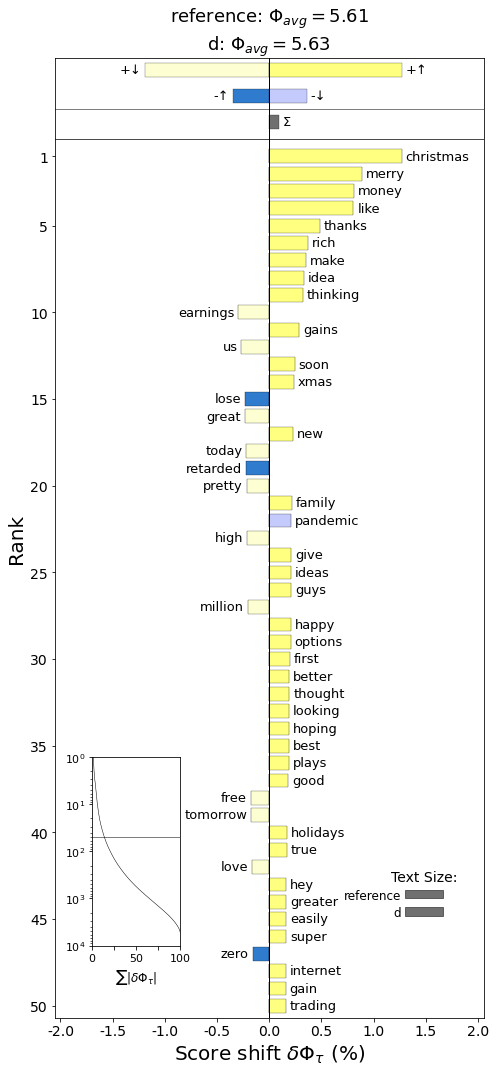

<AxesSubplot:title={'center':'reference: $\\Phi_{avg}=$5.61\nd: $\\Phi_{avg}=$5.63'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [53]:
# 2-8
sentiment_sh = sh.WeightedAvgShift(type2freq_1=p_ref,
                                  type2freq_2=p,
                                  type2score_1=labMt_dict,
                                  reference_value=5)
sentiment_sh.get_shift_graph(detailed=True,
                            system_names = ['reference', 'd'])

Happiness score increased by 0.02 point compare to reference. Positive word 'christmas', 'merry', 'money' appeared more on day d that had a significant impact. Positive word 'earning' appeared less. On the other hand, negative word 'lose' and 'retarded' appeared more when 'pandemic' appeared less on day d compared to reference.

>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

Words printed in step 6, which is top 10 tokens, ordered by the absolute value of $|\delta \Phi|$ showed on highest rank in the WordShift. 

## Part 3: Communities for the Zachary Karate Club Network

_Exercise: Zachary's karate club_: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html).

> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
<img src="https://github.com/lalessan/comsocsci2021/raw/master/files/karate.png" alt="Drawing" style="width: 200px;"/>

({'xlim': [0, 466],
  'ylim': [0, 466],
  'linkColor': '#7c7c7c',
  'linkAlpha': 0.5,
  'nodeStrokeColor': '#555555',
  'nodeStrokeWidth': 1.6428294155704122,
  'links': [{'source': 0,
    'target': 1,
    'width': 3.2856588311408244,
    'weight': 1},
   {'source': 0, 'target': 2, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 3, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 4, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 5, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 6, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 7, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 8, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 10, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 11, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 0, 'target': 12, 'width': 3.2856588311408244, 'weight': 1},
   {'source': 

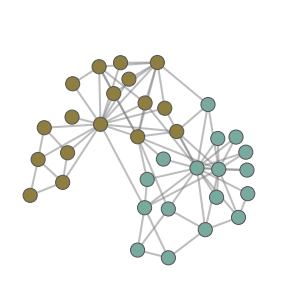

In [54]:
G = nx.karate_club_graph()
#nx.info(G0)
G0= nw.get_filtered_network(G,node_group_key='club')
nw.visualize(G0)

> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
$$ M = \sum\limits_{c = 1}^{n_c } {\left[ {\frac{{L_c }}{L} - \left( {\frac{{k_c }}{{2L}}} \right)^2 } \right]}  \hspace{20 mm} (9 . 12) $$

In [55]:
def Mod(G,C):
    count=list(set([i for i in C.values()]))
    #print(count) #社区名
    #print(len(count)) #社区数量

    n_c=len(count)
    L=G.number_of_edges()
    M=0

    for c in range(0,n_c):
        sub=[]
        L_c=0
        k_c=0
        #i=0
        for n in G.nodes:
            if G.nodes[n]["group"]==c:
                #i+=1
                k_c+=G.degree(n)
                sub.append(n)    
        L_c=G.subgraph(sub).number_of_edges()
        #print(L_c)
        #print(k_c)
        #print('number of nodes:',i)
        M+=(L_c/L)-pow((k_c/(2*L)),2)

    return M

> 3. Explain in your own words the concept of _modularity_. 

<font color=blue>
    Modularity can be used to determine how good the community segmentation results are. The larger the modularity, the better the community classification, and the best clustering result is when the result is between 0.3 and 0.7.
</font>

> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.



In [56]:
club = nx.get_node_attributes(G,'club')
#print(club)
Q=Mod(G0,club)
print(Q)

0.3582347140039447


> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network. 
>       * __b.__ Consider the list of network edges. Create two lists: the list of source nodes and target nodes. (e.g. edges = [(1,2),(3,4)], sources = [1,3], targets = [2,4])
>       * __c.__ Concatenate the list of source nodes and target nodes into a unique list (e.g. [1,3,2,4]). This is the list of _stubs_ (see the [Wikipedia page](https://en.wikipedia.org/wiki/Configuration_model) for the definition of stub).
>       * __d.__ Shuffle the list of stubs. Build a set of edges (tuples), by connecting each element in the list of shuffled stubs with the following element. (e.g. [4,1,2,3] --> [(4,1),(2,3)])
>       * __e.__ Remove all the original network edges from your network. Add all the new _shuffled_ edges you created in step __d.__



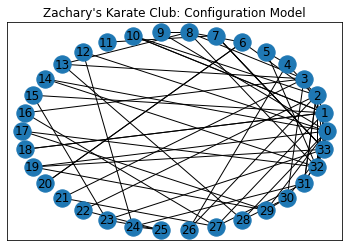

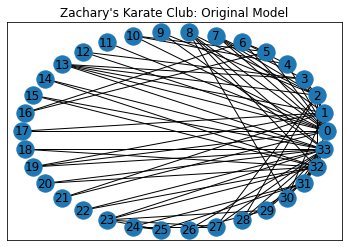

In [57]:
sequence=[]
for n in G.nodes:
    sequence.append(G.degree(n))
#print(sequence)

G_CM = nx.configuration_model(sequence)
#print(nx.info(G_CM))
#print(nx.info(G))

pos = nx.circular_layout(G_CM)

nx.draw_networkx(G_CM,pos)
plt.title("Zachary's Karate Club: Configuration Model")

plt.show()

nx.draw_networkx(G,pos)
plt.title("Zachary's Karate Club: Original Model")
plt.show()



> 6. Is the degree of the nodes in your original and the configuration model network the same? Why? 

__Note 1:__ With this algorithm you may obtain some self-loops. Note that [a self-loop should add two to the degree](https://en.wikipedia.org/wiki/Loop_(graph_theory%29#:~:text=For%20an%20undirected%20graph%2C%20the,adds%20two%20to%20the%20degree.&text=In%20other%20words%2C%20a%20vertex,not%20one%2C%20to%20the%20degree.). 

__Note 2:__ With this algorithm, you could also obtain repeated edges between the same two nodes. Only NetworkX [MultiGraph](https://networkx.org/documentation/stable/reference/classes/multigraph.html) allow for repeated edges, while regular [Graph](https://networkx.org/documentation/stable/reference/classes/graph.html?highlight=graph%20undirected#networkx.Graph) do not, meaning you will not be able to account for multi-edges when you have a regular Graph. (_Optional_: if you want to implement a configuration model without self-loops and multi-edges, you can try out the [double_edge_swap](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html) algorithm)



In [58]:
DG1=[]
DG2=[]

for n in G.nodes:
    DG1.append(G.degree(n))
for n in G_2.nodes:
    DG2.append(G_2.degree(n))

if DG1 == DG2:
    print('YES')
else:
    print('NO')
        
print('Degree of nodes of Graph 1:',DG1)
print('Degree of nodes of Graph 2:',DG2)

NameError: name 'G_2' is not defined

<font color=blue> Because the configuration model is a method for generating random networks from a given degree sequence.

> 7. Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.



In [ ]:
clublist=[]
sum=0
for n in range(0,1000):
    #print(n)
    G_N = nx.configuration_model(sequence)
    #C_N = community_louvain.best_partition(G_N) #使用Louvain算法进行分区
    nx.set_node_attributes(G_N, club, 'club')#设置节点属性
    G_N = nw.get_filtered_network(G_N,node_group_key='club')
    M_N=Mod(G_N,club)
    clublist.append(M_N)
    sum+=M_N
print(clublist)

> 8. Compute the average and standard deviation of the modularity for the configuration model.

In [ ]:
ave=sum/1000
print(ave)

> 9. Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

In [ ]:
y=[]
for n in range(0,1000):
    y.append(n)
    
plt.scatter(clublist,y)
plt.axvline(Q)

plt.title("Distribution of the ZKC Configuration Model Modularity")
plt.show()

> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?

+ <font color=blue>It's a very good partitioning.</font>
+ <font color=blue>Because it can be clearly seen the difference of modularity between the community network and random network.</font>
+ <font color=blue></font><font color=blue>Ensure that modular differences are not influenced by node degrees, but by links - and different links make communities</font>

> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [ ]:
C = community_louvain.best_partition(G) #使用Louvain算法进行分区
nx.set_node_attributes(G, C, 'louvain')#设置节点属性
G_louvain = nw.get_filtered_network(G,node_group_key='louvain')

nw.visualize(G_louvain)

In [ ]:
print('Modularity of Greedy-algorithm Grapy:',Q)
MLV=community_louvain.modularity(C, G_louvain)
print('Modularity of Louvain-algorithm Grapy:',MLV)

<font color=blue>Higher.</font>
+ <font color=blue>Different modularity values for different algorithmic partitions.</font>
+ <font color=blue>Better partitions have higher modularity values.</font>

> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [ ]:
n = 2
m = 3
D = [None]*n
for i in range(len(D)):
    D[i] = [0]*m
print(D)

_Exercise: Community detection on the GME network._
> * Consider the GME network you built in [Week 4](https://github.com/lalessan/comsocsci2022/blob/main/lectures/Week4.ipynb), part 2.
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.